# CNNチュートリアル(tensorflow)
MNISTを用いた簡単なチュートリアルについて説明します  
わからない部分や間違ってると感じた部分については質問してください  
なお、関連記事は大量にあるため、そちらの方も調べていただけるとより理解が増すと思います

## 実行環境
- macOS Sierra
- python3.6
- pip3

## 必要なライブラリのインポート

In [45]:
%matplotlib inline
import numpy as np
import matplotlib as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

## データの読み込み
今回は機械学習においてもっともポピュラーであるMNISTデータセットを用いていきます  
このデータセットは0から9の手書き数字で構成されており、与えられた未知の手書き数字の画像が0から9のどれであるかについて判定するタスクのために用いられることが多いです  
データの読み込みについては今回は深く扱わず、ライブラリから使用します  
データセットの内訳としては
- train
- validation
- test  

となっており、今回はtrainデータを学習用とし, testデータをテスト用として扱います  
引数の中に指定されているone_hotというのは、ラベルの表現方法です   
例えばある手書き数字画像が"3"である場合、正解ラベルを  
[0 0 0 1 0 0 0 0 0 0]  
と表現します。このラベルと画像を紐づけて学習を進めることになります

In [46]:
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)
print(mnist)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x10fb96c50>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x11c579908>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x12b34d9e8>)


## 扱うモデルについて
今回は中間層が2層のシンプルな構造を扱います  


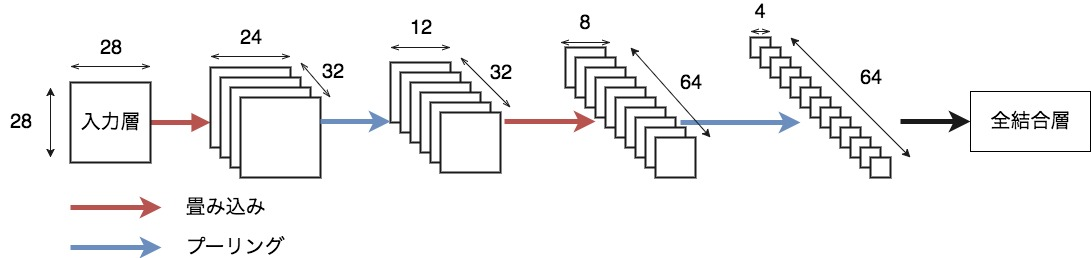

畳み込みとプーリングがセットで一つの層を表し、2層を経て全結合層に進みます  
### 全体の流れ
データセット用意 -> モデル構築 -> 学習 -> 予測  
という流れで行います。一度モデルは完成させる必要があります

### 入力層と出力層
入力層は学習させる画像の形式の指定を行うと考えれば良いです。与えられたデータの形式と適用したいモデルの入力形式に合わせて適宜reshapeをかけると良いでしょう  
出力層では、0から9のどれかを示すため, (,10)の形式で結果が出力されるようにします  
また、学習が始まるまでは値が決まらないため, placeholderを用いて仮のデータとして構築を進めることになります

In [47]:
#入力層x,出力層yの設定
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

#(1,784) -> (28,28)の変換
x_image = tf.reshape(x, [-1,28,28,1])

### 関数定義
高い頻度で呼ばれるようなコード部分を関数化します。実装の仕方は人それぞれですが、基本的にtensorflowにあるライブラリを用いると比較的楽に実装できるはずです  
それぞれの関数の中身については、tensorflowの本家サイトに掲載されているものばかりなので、各自で調べてください

In [50]:
# 重みの定義
def w_val(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

# バイアスの定義
def b_val(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

# 畳み込み関数
# x: 対象となる層
# W: フィルタ
def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

# プーリング関数
def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')

### 各層の構築
中間層2層と出力層について構築します  
先ほど定義した関数を用いて畳み込みやプーリング処理を行い、適宜活性化関数を挟みながら構築します

In [51]:
#第一層
W_conv1 = w_val([3, 3,1,32])
b_conv1 = b_val([32])
#ReLU
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
#プーリング
h_pool1 = max_pool_2x2(h_conv1)

#第二層
W_conv2 = w_val([3, 3,32,64])
b_conv2 = b_val([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#全結合層
W_fc1 = w_val([7 * 7 * 64, 1024])
b_fc1 = b_val([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

#Softmax層
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

### 誤差関数, 最適化関数等
学習を進めるに当たって、誤差を反映させたり学習を収束する上で最適化を行うことはとても重要です  
今回は
- 誤差関数: クロスエントロピー
- 最適化: Adam
を用います。それぞれの計算式の詳細は各自調べるようにしてください

In [52]:
# 誤差関数
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
# 誤差関数を最小化するようなAdam
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# 学習したモデルが予測した結果があっているか判定
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
# 精度計算
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### 学習
いよいよ学習に入ります。最初に初期化した上で学習を進めていきます。基本的にモデルがきちんと構築されていれば学習は進むはずなので、失敗した場合は適宜見直していきましょう  
- epoc数...200
- batch size...50

In [55]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
for i in range(2000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 0, training accuracy 0.14
step 100, training accuracy 0.82
step 200, training accuracy 0.92
step 300, training accuracy 0.94
step 400, training accuracy 0.86
step 500, training accuracy 1
step 600, training accuracy 0.98
step 700, training accuracy 0.92
step 800, training accuracy 0.94
step 900, training accuracy 0.98
step 1000, training accuracy 0.96
step 1100, training accuracy 0.92
step 1200, training accuracy 0.96
step 1300, training accuracy 0.9
step 1400, training accuracy 1
step 1500, training accuracy 0.98
step 1600, training accuracy 1
step 1700, training accuracy 0.94
step 1800, training accuracy 0.94
step 1900, training accuracy 0.94


学習の様子を見る限り、うまく学習が進んでいることが推測されます  
今回はそれで終わりではなく、テストデータを用いて未知の画像に対してどれだけの精度をあげられるかについて確かめます

In [56]:
print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
sess.close()

test accuracy 0.9699


未知の画像に対しても96%の精度で正解を当てることができることがわかります

## おまけ
畳み込み計算時のpaddingについて  
先ほど畳み込みの計算時(conv2d)に指定したpaddingはVALIDでした。これは掲載した図に沿ったもので、よくコードを検索するとpadding='SAME'となっていることが多いです  
そこで以下に計算の違いについて実験したものがあります。結果から見ると、SAMEの場合の畳み込みは入力のサイズを保持することがわかると思います  
それぞれの計算結果に大きな違いはなく(おそらく)、最終的な全結合層を想像しやすいpadding='SAME'の方が好まれるため、多くのコードは'SAME'で指定しているのだと思います

In [42]:
sess = tf.Session()
batch_size = 1

l = tf.constant(0.1, shape=[batch_size, 6, 6, 1])
w = tf.constant(0.1, shape=[3, 3, 1, 1])
b = tf.constant(0.1, shape=[3])
strides = [1, 1, 1, 1]

h1_SAME = tf.nn.conv2d(l, w, strides=strides, padding='SAME')
h1_VALID = tf.nn.conv2d(l, w, strides=strides, padding='VALID')

h1_SAME_pool = tf.nn.max_pool((h1_SAME+b),ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')
h1_VALID_pool = tf.nn.max_pool((h1_VALID+b),ksize=[1,2,2,1], strides=[1,2,2,1],padding='SAME')
print("When padding=SAME")
print(sess.run(h1_SAME).shape)
print(sess.run(h1_SAME_pool).shape)
print("When padding=VALID")
print(sess.run(h1_VALID).shape)
print(sess.run(h1_VALID_pool).shape)

When padding=SAME
(1, 6, 6, 1)
(1, 3, 3, 3)
When padding=VALID
(1, 4, 4, 1)
(1, 2, 2, 3)
